## Taxonomy Cleaning using Graph Theory

### Pre-process the prompting

In [1]:
import os
import pandas as pd
from collections import defaultdict
import networkx as nx
import re
import copy
from tqdm import tqdm
import numpy as np

In [2]:
PATH = './results/whole_graph'
prompt_files = ['wikiall0.tsv', 'wikiall1.tsv', 'wikiall2.tsv']

In [3]:
# read llm response
data = []
for file in prompt_files:
    with open(os.path.join(PATH, file), 'r') as pt_reader:
        qids = None
        explanation = []
        answer = None
        
        for line in pt_reader:
            line = line.strip()
            if line:
                if line.startswith('Explanation:'):
                    # Start a new explanation, capturing all subsequent lines until 'Answer:'
                    explanation = [line]
                elif line.startswith('Answer:'):
                    # Only Capture the first Answer generated
                    answer = line
                    if qids is not None:
                        data.append({
                            'QIDs': qids,
                            'Explanation': ' '.join(explanation),
                            'Answer': answer
                        })
                        # Reset for the next block
                        qids = None
                        explanation = []
                        answer = None
                elif line.startswith('wd:'):
                    qids = line.split('\t')
                else:
                    explanation.append(line)
        
        if qids is not None:
            data.append({
                'QIDs': qids,
                'Explanation': ' '.join(explanation),
                'Answer': answer
            })

**Observations:**
* If 'Answer' are followed by some additional explaination or additional notes. Then this answer maybe doutable, we will then extract the correct answer after the direct Answer


In [4]:
def find_first_rel_index(text, substrings):
    # a regex pattern that matches any of the substrings
    pattern = "|".join(re.escape(sub) for sub in substrings)
    match = re.search(pattern, text)
    return match.start() if match else -1


def identify_negations(text):
    relations = ['equivalent', 'superclass', 'subclass', 'irrelevant']
    negated = {relation: None for relation in relations}
    text = re.sub(r'\b(and|but|however)\b', ';', text, flags=re.IGNORECASE)

    segments = re.split(r'[;.]\s*', text)
    for segment in segments:
        for relation in relations:
            # negative relation statement
            neg_pattern = rf"(not|no|neither|nor|irrelevant|irrelevent|irrevelant|unrelated)\s*(.*?)?(a\s)?({relation})"
            neg_matches = re.findall(neg_pattern, segment, re.IGNORECASE)
            for negation, _, _, relation in neg_matches:
                if negation:
                    negated[relation.lower()] = True
            
            # positive relation statement
            if not re.search(r'\b(not|isn\'t|aren\'t)\b', segment) \
                and negated[relation.lower()] is None:
                pos_matches = re.findall(rf'\b({relation})\b', text, re.IGNORECASE)
                if pos_matches:
                    negated[relation.lower()] = False            

    return negated

In [5]:
correct_answer_paradim = [
    "it would be most accurate to state",
    "the most accurate answer would be",
    "it's more accurate to say that",
    "the most suitable answer",
    "i would suggest",
]
none_paradim = [
    "none",
    "there is no semantic relation",
    "there is no clear semantic relationship",
    "there isn't a clear semantic relationship",
    "there isn't a direct semantic relationship",
    "no direct semantic relationship",
    "no definitive semantic relationship",
    "not possible to accurately determine",
    "no hierarchical relationship",
]
rels = ['irrelevant', 'subclass', 'superclass', 'equivalent']

def process_prompt(answer):
    answer = answer.lower()
    for nparam in none_paradim:
        if nparam in answer:
            answer = 'none'
            break
    
    # When answering with doubts
    if len(answer.strip().split()) > 15:
        # get the first sentence
        splt_ = answer.strip().split('. ')
        # identify negations
        negated_res = identify_negations(splt_[0])
        if negated_res['irrelevant'] is True or negated_res['subclass'] is True or \
            negated_res['superclass'] is True or negated_res['equivalent'] is True:
            # avoid 'not' is behind the relation statement
            a_index = splt_[0].find('concepta')
            b_index = splt_[0].find('conceptb')
            not_index = splt_[0].find(' not ')
            rel_index = find_first_rel_index(splt_[0], rels)
            if a_index > 0 and b_index > 0 and rel_index > 0\
                and not_index > max(a_index, b_index) and not_index > rel_index:
                answer = answer[:not_index]
                return answer
            
            # handle doubt paradigms
            if 'therefore' in answer:
                answer = answer[answer.find('therefore'):]
                if 'instead' in answer:
                    answer = answer[answer.find('instead'):]
                return answer

            if 'instead' in answer:
                answer = answer[answer.find('instead'):].strip().split('. ')[0]
                return answer
            
            skipped = False
            for paradim in correct_answer_paradim:
                if paradim in answer:
                    answer = answer[answer.find(paradim):].strip().split('. ')[0]
                    skipped = True
                    break
            
            if skipped:
                return answer
            
            # deal with the negations
            negated_res = identify_negations(answer)
            neg_irrel = negated_res['irrelevant']
            neg_sub = negated_res['subclass']
            neg_sup = negated_res['superclass']
            neg_eq = negated_res['equivalent']
            if neg_eq and neg_sub and neg_sup:
                answer = 'none'
                return answer
            
            if neg_irrel is False:
                answer = 'irrelevant'
                return answer

            if neg_sub is False or neg_sup is False:
                answer = 'conceptb is subclass of concepta'
                return answer

            if neg_eq is False:
                answer = 'equivalent'
                return answer
            
            # If none of the above situations satisfy, then the answer is 'none'.
            answer = 'none'
        else:
            answer = splt_[0]
    return answer

In [6]:
# pre-process llm prompts
data_copy = copy.deepcopy(data)
for block in tqdm(data_copy):
    answer = block['Answer']
    answer = process_prompt(answer)
    data[data.index(block)]['Answer'] = answer

100%|██████████| 52826/52826 [01:35<00:00, 550.58it/s] 


In [7]:
# Get the prompt results for each relation
llm_res = []
for block in tqdm(data):
    rel = tuple(block['QIDs'])
    answer = block['Answer']
    if answer.find('none') >= 0 or answer.find(' not ') >= 0:
        answer = '[NONE]'
    
    a_idx = answer.find('concepta')
    b_idx = answer.find('conceptb')
    if a_idx >= 0 or b_idx >= 0:
        if a_idx < b_idx and a_idx >= 0:
            if answer.find('subclass') >= 0:
                answer = '[INVERSE]'
            elif answer.find('superclass') >= 0:
                answer = '[SUPERCLASS]'
            elif answer.find('equivalent') >= 0 or answer.find('equivlant') >= 0 or \
                answer.find('equivant') >= 0 or answer.find('synonym') >= 0:
                answer = '[EQUIV]'
            elif answer.find('irrelevant') >= 0 or answer.find('irrelevent') >= 0 or \
                answer.find('irrelevance') >= 0 or answer.find('irrevelant') >= 0:
                answer = '[IRREL]'
            else:
                answer = '[NONE]'
            
        if b_idx < a_idx and b_idx >= 0:
            if answer.find('subclass') >= 0:
                answer = '[SUPERCLASS]'
            elif answer.find('superclass') >= 0:
                answer = '[INVERSE]'
            elif answer.find('equivalent') >= 0:
                answer = '[EQUIV]'
            elif answer.find('irrelevant') >= 0 or answer.find('irrelevent') >= 0 or \
                answer.find('irrelevance') >= 0 or answer.find('irrevelant') >= 0:
                answer = '[IRREL]'
            else:
                answer = '[NONE]'
        if a_idx >= 0 and b_idx < 0:
            if answer.find('subclass') >= 0 and (answer.find('subclass') < a_idx):
                answer = '[SUPERCLASS]'
            elif answer.find('superclass') >= 0 and (answer.find('superclass') < a_idx):
                answer = '[INVERSE]'
            elif answer.find('irrelevant') >= 0:
                answer = '[IRREL]'
            else:
                answer = '[NONE]'
        if b_idx >= 0 and a_idx < 0:
            if answer.find('superclass') >= 0 and (answer.find('superclass') < b_idx):
                answer = '[SUPERCLASS]'
            elif answer.find('subclass') >= 0 and (answer.find('subclass') < b_idx):
                answer = '[INVERSE]'
            elif answer.find('irrelevant') >= 0:
                answer = '[IRREL]'
            else:
                answer = '[NONE]'
    else:
        if answer.find('irrelevant') >= 0 or answer.find('irrelevent') >= 0:
            answer = '[IRREL]'
        elif answer.find('subclass') >= 0 or answer.find('superclass of') >= 0:
            answer = '[SUPERCLASS]'
        elif answer.find('equivalent') >= 0:
            answer = '[EQUIV]'
        else:
            answer = '[NONE]'
    
    # check before noting
    if answer.startswith('['):
        llm_res.append({
            'relation': rel,
            'llm_answer': answer
        })
    else:
        raise ValueError(f"Answer not valid: {answer}")

  0%|          | 0/52826 [00:00<?, ?it/s]

100%|██████████| 52826/52826 [00:00<00:00, 493442.03it/s]


In [8]:
none_edges = []
irrel_edges = []
equiv_edges = []
inverse_edges = []
correct_edges = []
for block in llm_res:
    if block['llm_answer'] == '[NONE]':
        none_edges.append(block['relation'])
    elif block['llm_answer'] == '[IRREL]':
        irrel_edges.append(block['relation'])
    elif block['llm_answer'] == '[EQUIV]':
        equiv_edges.append(block['relation'])
    elif block['llm_answer'] == '[SUPERCLASS]':
        correct_edges.append(block['relation'])
    elif block['llm_answer'] == '[INVERSE]':
        inverse_edges.append(block['relation'])
    else:
        raise ValueError(f"Answer not valid: {block['llm_answer']}")

print(f"NONE: {len(none_edges)}, Percentage: {np.round(len(none_edges) * 100 / len(llm_res), 2)}%")
print(f"IRREL: {len(irrel_edges)}, Percentage: {np.round(len(irrel_edges) * 100 / len(llm_res), 2)}%")
print(f"EQUIV: {len(equiv_edges)}, Percentage: {np.round(len(equiv_edges) * 100 / len(llm_res), 2)}%")
print(f"INVERSE: {len(inverse_edges)}, Percentage: {np.round(len(inverse_edges) * 100 / len(llm_res), 2)}%")
print(f"SUPERCLASS: {len(correct_edges)}, Percentage: {np.round(len(correct_edges) * 100 / len(llm_res), 2)}%")

NONE: 3354, Percentage: 6.35%
IRREL: 6741, Percentage: 12.76%
EQUIV: 1364, Percentage: 2.58%
INVERSE: 1567, Percentage: 2.97%
SUPERCLASS: 39800, Percentage: 75.34%


In [12]:
for edge in none_edges:
    print(edge, cls2label[edge[0]], ';', cls2label[edge[1]])

('wd:Q35120', 'wd:Q2995644') entity ; result
('wd:Q7048977', 'wd:Q107633348') abstract entity ; relay team
('wd:Q7048977', 'wd:Q12488383') abstract entity ; content
('wd:Q7048977', 'wd:Q450') abstract entity ; mind
('wd:Q7048977', 'wd:Q122258005') abstract entity ; abstract reference point
('wd:Q7048977', 'wd:Q105943409') abstract entity ; cryptographic token
('wd:Q7048977', 'wd:Q859965') abstract entity ; game item
('wd:Q24238356', 'wd:Q4316069') unknown ; undeciphered language
('wd:Q215627', 'wd:Q19381254') person ; medalist
('wd:Q215627', 'wd:Q502931') person ; humanoid
('wd:Q1914636', 'wd:Q1455167') activity ; accommodation outside parental care
('wd:Q1914636', 'wd:Q214961') activity ; improvisation
('wd:Q1914636', 'wd:Q3604747') activity ; acquisition
('wd:Q1914636', 'wd:Q210603') activity ; extradition
('wd:Q1914636', 'wd:Q11771944') activity ; civil service
('wd:Q1914636', 'wd:Q4350217') activity ; redistribution of property
('wd:Q1914636', 'wd:Q4989857') activity ; emigrant
('w

* Data from the original taxonomy

In [46]:
topwikitaxonUp = defaultdict(set)
topWikitaxonDown = defaultdict(set)
with open('./data/topWikiTaxonUp.tsv', 'r') as topreader:
    for line in topreader:
        child, parent = line.strip().split('\t')
        topwikitaxonUp[child].add(parent)
        topWikitaxonDown[parent].add(child)

graph = nx.DiGraph(topWikitaxonDown)
# Graph properties
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if not list(graph.predecessors(node))]))
graph.number_of_edges(), graph.number_of_nodes() # original nodes, original edges

Is DAG? True
Is connected? True
Max Depth: 15
Number of roots: 1


(52826, 38261)

In [9]:
import utils

Wiki_class_labels = "/home/infres/ypeng-21/work/Taxon_clean/build_dataset/test/build_data_from_nt/24_03_22/raw_data/wikidata_src/wiki_taxonomy_labels.tsv"
Wiki_class_descriptions = "/home/infres/ypeng-21/work/Taxon_clean/build_dataset/test/build_data_from_nt/24_03_22/raw_data/wikidata_src/wiki_taxonomy_description.tsv"

cls2label = utils.load_label(Wiki_class_labels)
cls2desc = utils.load_desc(Wiki_class_descriptions)

/home/infres/ypeng-21/anaconda3/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


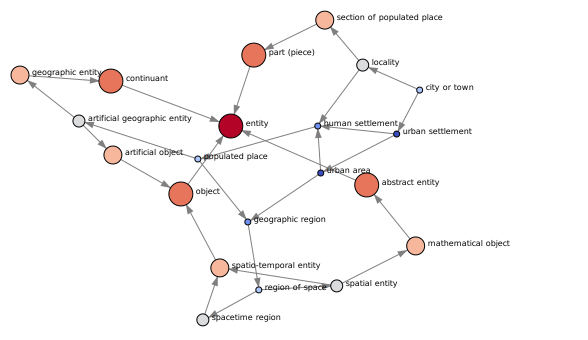

In [11]:
import warnings
warnings.filterwarnings("ignore")
from sknetwork.path import get_distances, breadth_first_search
from sknetwork.visualization import svg_graph
from IPython.display import SVG
import networkx as nx
from scipy.sparse import csr_matrix

adjacency = csr_matrix(nx.adjacency_matrix(graph).toarray())
names = list(graph.nodes)
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q7930989')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8)
SVG(image)

In [47]:
graph1 = copy.deepcopy(graph)

### Taxonomy Cleaning

1. Delete '[IRREL]' edges
2. Delete '[NONE]' edges

In [15]:
def getSuperClasses(cls, classes, WikiTaxonomyUp):
    """Adds all superclasses of a class <cls> (including <cls>) to the set <classes>"""
    classes.add(cls)
    # Make a check before because it's a defaultdict,
    # which would create cls if it's not there
    if cls in WikiTaxonomyUp:
        for sc in WikiTaxonomyUp[cls]:
            getSuperClasses(sc, classes, WikiTaxonomyUp)      

def getAncestors(cls, WikiTaxonomyUp):
    """Returns the set of all parent classes of <cls> (including <cls>!)"""
    classes=set()
    getSuperClasses(cls, classes, WikiTaxonomyUp)        
    return classes

# The cumulative stats is for instances of classes
def cumulative_stats(stats, topTaxonomyUp):
    """Cumulative statistics of classes"""
    cum_stats = defaultdict(int)
    for instantiated_cls in stats.keys():
        ancestors = getAncestors(instantiated_cls, topTaxonomyUp) # including cls itself
        for ancestor in ancestors:
            cum_stats[ancestor] += stats[instantiated_cls]
    return cum_stats

In [16]:
df = pd.read_csv('./data/cls_inst_count.txt', sep='\t', header=None, names=['cls', 'count'])
cls_cum = pd.read_csv('./data/cum_cls_inst_stats.txt', sep='\t', header=None, names=['cls', 'count']).set_index('cls').to_dict()['count']
leaves = set([node for node in graph.nodes() if graph.out_degree(node) == 0])
for index, row in tqdm(df.iterrows()):
    if row['cls'] in leaves:
        df.at[index, 'count'] = cls_cum[row['cls']]
cls_stats = df.set_index('cls').to_dict()['count']

69714it [00:02, 23386.46it/s]


In [36]:
len(cls_stats)

69714

#### Delete strategy:
* Remove all irrelevant edges, following the order from top to down
    * i.e. special case for no parent situation. upper class is more abstract and large grapdularity which can cause irrelavant errors, following order to avoid big pruning of reasonable nodes.
* Delete nodes that aren’t reachable from root ‘entity(Q35120)’. (num_nodes deleted threshold = 5)
* Manully check unconnected components with size > 3 (size < 3 delete)
    * If make sense, then relink
    * Not make sense, then delete all nodes belongs to small components
* Post-processing:
    * transitive reduction
    * cumulative instance count filtering (count < 2)

In [17]:
import networkx as nx
from collections import deque

def bfs_edges_by_level(graph, root):
    visited = set()
    queue = deque([(root, 0)])
    # dictionary to hold edges by their depth level
    edges_by_level = {}

    while queue:
        node, depth = queue.popleft()
        if node not in visited:
            visited.add(node)
            for neighbor in graph.neighbors(node):
                edge = (node, neighbor)
                if depth not in edges_by_level:
                    edges_by_level[depth] = []
                edges_by_level[depth].append(edge)
                if neighbor not in visited:
                    queue.append((neighbor, depth + 1))
                    
    return edges_by_level

In [13]:
root = 'wd:Q35120'
edges_by_level = bfs_edges_by_level(graph, root)
bfs_edges = [] 
for depth in edges_by_level:
    bfs_edges.extend(edges_by_level[depth])

In [14]:
len(bfs_edges), graph.number_of_edges()

(52826, 52826)

In [15]:
# Remove edges
del_edges = set(irrel_edges + none_edges)
small_subgraph_count = 0
small_subgraph_list = []
del_unreachable_nodes_count = 0
count_del = 0
# del_unreachable_nodes_list = []
# del_edge_list = []

unconnect_edges = []
for edge in tqdm(bfs_edges):
    # Skip first-level classes
    if edge[0] == 'wd:Q35120':
        continue
    
    if graph.has_edge(edge[0], edge[1]) and (edge in del_edges):
        if graph.in_degree(edge[1]) > 1:
            # remove edge if child has multiple parents
            graph.remove_edge(edge[0], edge[1])
            continue
        else:
            graph.remove_edge(edge[0], edge[1])
            if not nx.is_weakly_connected(graph):
                components = list(nx.weakly_connected_components(graph))
                assert len(components) == 2
                if len(components[1]) < len(components[0]) \
                    and len(components[1]) < 4: # remove small subgraph with <= 3 nodes
                    small_subgraph_count += 1
                    small_subgraph_list.append(components[1])
                    for node in components[1]:
                        graph.remove_node(node)
                    continue
                unconnect_edges.append(edge)
                graph.add_edge(edge[0], edge[1])
            elif not nx.has_path(graph, 'wd:Q35120', edge[1]):
                # weakly connected but having multiple roots
                del_unreachable_nodes_count += 1
                del_nodes_set = set()
                for node in graph.nodes():
                    if not nx.has_path(graph, 'wd:Q35120', node):
                        del_nodes_set.add(node)
                    if len(del_nodes_set) > 5:
                        # no delete anymore
                        graph.add_edge(edge[0], edge[1])
                        break
                
                if len(del_nodes_set) <= 5:
                    count_del += 1
                    for node in del_nodes_set:
                        if graph.has_node(node):
                            graph.remove_node(node)

# Statistics
print(f'Unconnected edges:{len(unconnect_edges)}, percentage:{np.round(len(unconnect_edges) * 100 / len(del_edges), 2)}')
print(f'Small subgraph count:{small_subgraph_count}')
print(f'Deleted unreachable nodes count:{count_del}/{del_unreachable_nodes_count} = {np.round(count_del*100/del_unreachable_nodes_count, 2)}')

100%|██████████| 52826/52826 [14:47<00:00, 59.54it/s]  


In [16]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 19
Number of roots: 1


(41332, 32997)

In [ ]:
graph2 = copy.deepcopy(graph)

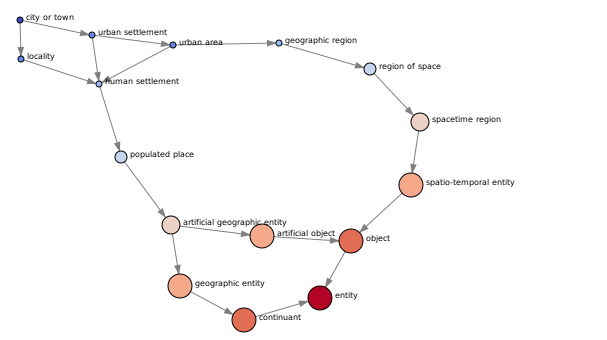

In [20]:
import warnings
warnings.filterwarnings("ignore")
from sknetwork.path import get_distances, breadth_first_search
from sknetwork.visualization import svg_graph
from IPython.display import SVG
import networkx as nx
from scipy.sparse import csr_matrix

adjacency = csr_matrix(nx.adjacency_matrix(graph).toarray())
names = list(graph.nodes)
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q7930989')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8)
SVG(image)

In [ ]:
# # cumulative stats
# min_cum_count = 2
# tmpTaxonUp = nx.to_dict_of_lists(graph.reverse())
# cum_stats = cumulative_stats(cls_stats, tmpTaxonUp)
# longtail_count = 0
# nodes = list(graph.nodes())
# for node in nodes:
#     if node not in cum_stats:
#         graph.remove_node(node)
#         longtail_count += 1
#     elif cum_stats[node] < min_cum_count:
#         graph.remove_node(node)
#         longtail_count += 1
# print("Longtail count:", longtail_count)

In [ ]:
# graph.number_of_edges(), graph.number_of_nodes()

In [ ]:
# graph = nx.transitive_reduction(graph)
# print("Is DAG?", nx.is_directed_acyclic_graph(graph))
# print("Is connected?", nx.is_weakly_connected(graph))
# print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
# print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
# graph.number_of_edges(), graph.number_of_nodes()

#### Merge classes

* Inverse edge (won't create cycles): ex. part(piece) -> iternary
    1. child has not only one parent; then we delete directly.
    2. single parent -> then we merge child -> parent.
* Equivalent edges: merge directly.

Exception: linear construction -> thoroughfare; become linear construction

In [14]:
tmpDown = defaultdict(set)
with open('./data/graph/clean_wikiTaxonUp2.tsv', 'r') as file:
    for line in file:
        child, parent = line.strip().split('\t')
        tmpDown[parent].add(child)
graph = nx.DiGraph(tmpDown)

In [18]:
root = 'wd:Q35120'
edges_by_level = bfs_edges_by_level(graph, root)
bfs_edges = [] 
for depth in edges_by_level:
    bfs_edges.extend(edges_by_level[depth])

In [19]:
len(bfs_edges), graph.number_of_edges()

(41299, 41299)

In [20]:
# Inverse edges
mapping = defaultdict(set)
inverse_edges_del = []
inverse_count_del = 0
inverse_count_merge = 0
for edge in tqdm(bfs_edges):
    parent, child = edge
    if edge not in set(inverse_edges):
        continue
    if graph.has_edge(parent, child):
        if graph.in_degree(child) > 1:
            graph.remove_edge(parent, child)
            # Yiwen: 2024-04-08
            inverse_edges_del.append(edge)
            inverse_count_del += 1
        else: # merge child to parent (single parent)
            for sc in graph.successors(child):
                graph.add_edge(parent, sc)
            graph.remove_node(child)
            inverse_count_merge += 1
            mapping[parent].add(child)
    if not nx.is_weakly_connected(graph):
        print('Not connected if remove edge:', edge)
        break

print(f"Inverse_count_del: {np.round(inverse_count_del*100 / len(inverse_edges), 2)}, Inverse_count_merge: {np.round(inverse_count_merge*100 / len(inverse_edges), 2)}")

  0%|          | 0/41299 [00:00<?, ?it/s]

100%|██████████| 41299/41299 [01:20<00:00, 511.08it/s] 

Inverse_count_del: 38.23, Inverse_count_merge: 52.58


In [21]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 15
Number of roots: 1


(39820, 32150)

In [24]:
inverse_edges_del

[('wd:Q48907157', 'wd:Q3257686'),
 ('wd:Q12893838', 'wd:Q6671777'),
 ('wd:Q4235019', 'wd:Q6999'),
 ('wd:Q65088916', 'wd:Q1933427'),
 ('wd:Q4406616', 'wd:Q28732711'),
 ('wd:Q170409', 'wd:Q56825824'),
 ('wd:Q11681141', 'wd:Q524158'),
 ('wd:Q24335044', 'wd:Q24336784'),
 ('wd:Q24335044', 'wd:Q16521098'),
 ('wd:Q24335044', 'wd:Q16513904'),
 ('wd:Q97669203', 'wd:Q15712714'),
 ('wd:Q121359', 'wd:Q46622804'),
 ('wd:Q337968', 'wd:Q33384'),
 ('wd:Q111191714', 'wd:Q81113235'),
 ('wd:Q27096235', 'wd:Q15642541'),
 ('wd:Q27096235', 'wd:Q35145743'),
 ('wd:Q52551684', 'wd:Q1620908'),
 ('wd:Q111752858', 'wd:Q17320256'),
 ('wd:Q920419', 'wd:Q55871434'),
 ('wd:Q1914636', 'wd:Q10843872'),
 ('wd:Q1914636', 'wd:Q309100'),
 ('wd:Q12888920', 'wd:Q1331926'),
 ('wd:Q64830866', 'wd:Q864114'),
 ('wd:Q386426', 'wd:Q43113623'),
 ('wd:Q1107656', 'wd:Q25506120'),
 ('wd:Q286583', 'wd:Q115668308'),
 ('wd:Q1049757', 'wd:Q1763828'),
 ('wd:Q1836700', 'wd:Q3406743'),
 ('wd:Q6498398', 'wd:Q193220'),
 ('wd:Q190157', 'wd:Q179

In [22]:
# which edges are merged
mapping

defaultdict(set,
            {'wd:Q15989253': {'wd:Q10888818',
              'wd:Q1310239',
              'wd:Q1529874',
              'wd:Q227505',
              'wd:Q23005640',
              'wd:Q56052926'},
             'wd:Q30241068': {'wd:Q483247'},
             'wd:Q2995644': {'wd:Q21075690'},
             'wd:Q20203388': {'wd:Q12769393'},
             'wd:Q14897293': {'wd:Q123461693'},
             'wd:Q28732711': {'wd:Q19829510'},
             'wd:Q116699470': {'wd:Q116700127'},
             'wd:Q4406616': {'wd:Q223557'},
             'wd:Q16686448': {'wd:Q3619132'},
             'wd:Q2424752': {'wd:Q3244175'},
             'wd:Q2342494': {'wd:Q18593264'},
             'wd:Q118870638': {'wd:Q222032'},
             'wd:Q3695082': {'wd:Q188889'},
             'wd:Q123057055': {'wd:Q53869933'},
             'wd:Q11019': {'wd:Q1882685', 'wd:Q30066789'},
             'wd:Q811909': {'wd:Q1364774', 'wd:Q839546'},
             'wd:Q35127': {'wd:Q18450215'},
             'wd:Q1753378': 

* Post-processing
    * Instance filtering (cumulative): retyping(as we have merge) + filtering
    * Transitive link reduction

In [38]:
graph3 = copy.deepcopy(graph)

In [39]:
# instance filtering
wikiTaxonUpAfterMerge = nx.to_dict_of_lists(graph.reverse())
oriWikiTaxonomyDown = defaultdict(set)
with open('./data/wiki_taxonomy.tsv', 'r') as f:
    for line in f:
        triple = line.strip().split('\t')
        if len(triple) > 3:
            oriWikiTaxonomyDown[triple[2]].add(triple[0])
ori_wiki = nx.DiGraph(oriWikiTaxonomyDown)

In [40]:
# store the edges deleted
edges_del = set(list(del_edges) + list(inverse_edges_del))
len(edges_del)
np.save('./data/evaluation/edges_del.npy', list(edges_del))

In [41]:
# Retyping
from itertools import permutations
global del_edges
global inverse_edges_del
global wikiTaxonUpAfterMerge
def get_ancestors(digraph, ancestors, cls):
    for sp in digraph.predecessors(cls):
        # path should not include irrelevant edges
        if tuple([sp, cls]) in del_edges or tuple([sp, cls]) in inverse_edges_del:
            continue
        if sp in wikiTaxonUpAfterMerge:
            ancestors.add(sp)
            continue
        get_ancestors(digraph, ancestors, sp)

def get_valid_first_ancestors(digraph, cls):
    ancestors = set()
    get_ancestors(digraph, ancestors, cls)
    return ancestors

# Process Retype
update_cls_stats = defaultdict(int)
for cls in cls_stats.keys():
    if graph.has_node(cls):
        update_cls_stats[cls] += cls_stats[cls]
        continue
    ancestors = list(get_valid_first_ancestors(ori_wiki, cls))
    if len(ancestors) == 1:
        update_cls_stats[ancestors[0]] += cls_stats[cls]
        continue
    if len(ancestors) > 0:
        # remove transitive parents
        valcls = ancestors.copy()
        for (node1,node2) in permutations(ancestors, 2):
            if node1 not in valcls or node2 not in valcls:
                continue
            if nx.has_path(graph, node1, node2):
                valcls.remove(node1)
        for c in valcls:
            update_cls_stats[c] += cls_stats[cls]
print("Number of instantiated classes before retyping:", len(set(graph.nodes()).intersection(set(cls_stats.keys()))))
print("Number of instantiated classes after retyping:", len(update_cls_stats))

# Filtering
MIN_CUMCOUNT = 2
cum_stats = cumulative_stats(update_cls_stats, wikiTaxonUpAfterMerge)
longtail_count = 0
nodes = list(graph.nodes())
for node in tqdm(nodes):
    if node not in cum_stats:
        graph.remove_node(node)
        longtail_count += 1
    elif cum_stats[node] < MIN_CUMCOUNT:
        # remove classes with only one instance
        graph.remove_node(node)
        longtail_count += 1
print("Longtail count:", longtail_count)

Number of instantiated classes before retyping: 28561
Number of instantiated classes after retyping: 29723


100%|██████████| 32175/32175 [00:00<00:00, 1117825.60it/s]

Longtail count: 6523


In [42]:
# transitive reduction
graph = nx.transitive_reduction(graph)

In [43]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 21
Number of roots: 1


(30175, 25652)

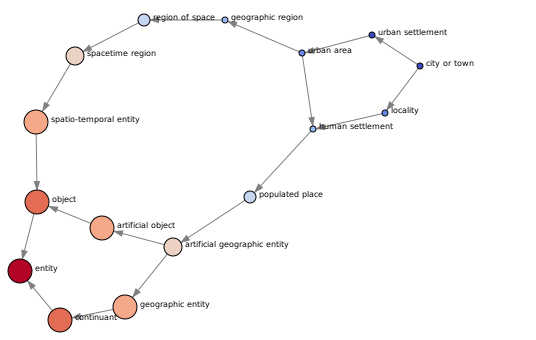

In [30]:
import warnings
warnings.filterwarnings("ignore")
from sknetwork.path import get_distances, breadth_first_search
from sknetwork.visualization import svg_graph
from IPython.display import SVG
import networkx as nx
from scipy.sparse import csr_matrix

adjacency = csr_matrix(nx.adjacency_matrix(graph4).toarray())
names = list(graph4.nodes)
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q7930989')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8)
SVG(image)

In [ ]:
graph4 = copy.deepcopy(graph)

#### Equivalent edges
* Merge equivalent edges and exact match concepts
* Merge: child merge to parent; keep parent
* Order: Top to Down
* Need to verify if we relink the parent -> child edge

In [29]:
wikidown = defaultdict(set)
with open('/home/infres/ypeng-21/work/Taxon_clean/LLM/data/graph/clean_wikiTaxonUp4.tsv', 'r') as file:
    for line in file:
        child, parent = line.strip().split('\t')
        wikidown[parent].add(child)
graph4 = nx.DiGraph(wikidown)

In [13]:
len(equiv_edges)

1364

In [26]:
# Exact Match filtering
# Extend the equivalent edges
for edge in graph.edges():
    parent, child = cls2label[edge[0]], cls2label[edge[1]]
    if parent.lower() == child.lower():
        # equiv_edges.append(edge)
        print(edge, parent, child)

('wd:Q3249551', 'wd:Q108743809') process process
('wd:Q3249551', 'wd:Q205663') process process
('wd:Q3249551', 'wd:Q10843872') process process
('wd:Q1454986', 'wd:Q28843577') physical system physical system
('wd:Q166142', 'wd:Q11320567') application application
('wd:Q701632', 'wd:Q2647159') municipal council municipal council
('wd:Q30022', 'wd:Q4236467') coffeehouse coffeehouse
('wd:Q102496', 'wd:Q7137411') parish parish
('wd:Q102496', 'wd:Q13358519') parish parish
('wd:Q7553219', 'wd:Q7553231') sodality Sodality
('wd:Q327333', 'wd:Q5659726') government agency government agency
('wd:Q159334', 'wd:Q10947886') secondary school secondary school
('wd:Q159334', 'wd:Q1314860') secondary school secondary school
('wd:Q294163', 'wd:Q10879990') public institution public institution
('wd:Q1371037', 'wd:Q6040928') institute of technology Institute of Technology
('wd:Q4189293', 'wd:Q4516014') rank rank
('wd:Q211364', 'wd:Q1550643') principle principle
('wd:Q986291', 'wd:Q504825') net net
('wd:Q4984

In [15]:
len(equiv_edges)

1517

In [17]:
root = 'wd:Q35120' # 'entity'
mergemap = {} # child -> parent merge map
relinkedParentTo = set() # prentTo edges relinked, need post-process
# mapping # already defined above

edges_by_level = bfs_edges_by_level(graph, root)
bfs_edges = [] 
for depth in edges_by_level:
    bfs_edges.extend(edges_by_level[depth])
print(len(bfs_edges),graph.number_of_edges())

# start merging equivalent classes
for edge in tqdm(bfs_edges):
    # we won't merge the first-level classes
    # e.g. entity -> object
    if edge[0] == root:
        continue
    # we won't consider continuous merge
    if not graph.has_edge(edge[0], edge[1]):
        continue
    if edge in set(equiv_edges):
        cur = edge[1]
        mergeTo = edge[0]
        # find the first valid parent, avoid already merged parent
        while mergeTo in mergemap:
            mergeTo = mergemap[mergeTo]
        for sc in graph.successors(cur):
            graph.add_edge(mergeTo, sc)
        for pc in graph.predecessors(cur):
            # avoid duplicates and contradiction
            if nx.has_path(graph, source=pc, target=mergeTo) or \
                nx.has_path(graph, source=mergeTo, target=pc):
                continue
            if pc == edge[0]:
                continue
            if graph.has_node(pc) and graph.has_node(mergeTo):
                # mergeToparents = set(graph.predecessors(mergeTo))
                # pcParents = set(graph.predecessors(pc))
                # # relink pc -> mergeTo if they are not siblings
                # if mergeToparents.isdisjoint(pcParents):
                #     relinkedParentTo.add(tuple([pc, mergeTo]))
                relinkedParentTo.add(tuple([pc, mergeTo]))
        # delete current node
        mergemap[cur] = mergeTo
        # mapping[mergeTo].add(cur)
        graph.remove_node(cur)
        # transitive reduction
        graph = nx.transitive_reduction(graph)

30001 30001


  0%|          | 0/30001 [00:00<?, ?it/s]

100%|██████████| 30001/30001 [10:10<00:00, 49.12it/s]  


In [51]:
# store the mapping file
mapping = defaultdict(set)
for node in graph.nodes():
    mapping[node].add(node) # clean -> ori, 实际情况调转一下就可以了
np.save('./data/evaluation/mapping.npy', mapping)

In [18]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 21
Number of roots: 1


(28682, 24508)

In [50]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 21
Number of roots: 1


(28678, 24506)

* important classes check

In [51]:
# Check if important classes are still in the graph
# Refer to YAGO4.5 design file: https://yago-knowledge.org/data/yago4.5/
# Creative work; Q17537576; Q386724
print("-Creative work-", "IncludeCls:", graph.has_node('wd:Q17537576'), 
      " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q17537576'))
print("-Creative work-", "IncludeCls:", graph.has_node('wd:Q386724'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q386724'))
# Book; Q571
print("-Book-", "IncludeCls:", graph.has_node('wd:Q571'), 
      " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q571'))
# Newspaper; Q11032
print("-Newspaper-", "IncludeCls:", graph.has_node('wd:Q11032'), 
      " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q11032'))
# TVSeries; Q5398426
print("-TVSeries-", "IncludeCls:", graph.has_node('wd:Q5398426'), 
      " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q5398426'))
# MusicComposition; Q207628; Q2188189
print("-MusicComposition-", "IncludeCls:", graph.has_node('wd:Q207628'))
print("-MusicComposition-", "IncludeCls:", graph.has_node('wd:Q2188189'))
print("-Music-", "IncludeCls:", graph.has_node('wd:Q638'))
# Movie, Q11424
print("-Movie-", "IncludeCls:", graph.has_node('wd:Q11424'), 
      " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q11424'))
# Event, Q1190554; Q1656682
print("-Event-", "IncludeCls:", graph.has_node('wd:Q1190554'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q1190554'))
print("-Event-", "IncludeCls:", graph.has_node('wd:Q1656682'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q1656682'))
# Election, Q40231
print("-Election-", "IncludeCls:", graph.has_node('wd:Q40231'))
print("-Election-", "IncludeCls:", graph.has_node('wd:Q189760')) # voting
print("-Election-", "IncludeCls:", graph.has_node('wd:Q12888920')) # selection
print("-Election-", "IncludeCls:", graph.has_node('wd:Q2135540')) # legal action
print("-Election-", "IncludeCls:", graph.has_node('wd:Q1864008')) # legal art
print("-Election-", "IncludeCls:", graph.has_node('wd:Q1331926')) # descision making
# Organization, Q43229
print("-Organization-", "IncludeCls:", graph.has_node('wd:Q43229'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q43229'))
# Corporation, Q783794; Q4830453
print("-Corporation-", "IncludeCls:", graph.has_node('wd:Q783794'))
print("-Corporation-", "IncludeCls:", graph.has_node('wd:Q4830453'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q4830453'))
# Airline, Q46970
print("-Airline-", "IncludeCls:", graph.has_node('wd:Q46970'))
print("-Airline-", "IncludeCls:", graph.has_node('wd:Q1875615')) # aircraft operator
# EducationalOrganization, Q5341295
print("-EducationalOrganization-", "IncludeCls:", graph.has_node('wd:Q5341295'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q5341295'))
# PerformingGroup, Q105815710
print("-PerformingGroup-", "IncludeCls:", graph.has_node('wd:Q105815710'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q105815710'))
# MusicGroup, Q2088357
print("-MusicGroup-", "IncludeCls:", graph.has_node('wd:Q2088357'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q2088357'))
# Person, Q5; Q215627
# print("-Person-", "IncludeCls:", graph.has_node('wd:Q5'),
#         " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q5'))
print("-Person-", "IncludeCls:", graph.has_node('wd:Q215627'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q215627'))
# Worker, Q702269, Q327055
print("-Worker-", "IncludeCls:", graph.has_node('wd:Q702269'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q702269'))
print("-Worker-", "IncludeCls:", graph.has_node('wd:Q327055'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q327055'))
# Creator, Q483501
print("-Creator-", "IncludeCls:", graph.has_node('wd:Q483501'))
print("-Creator-", "IncludeCls:", graph.has_node('wd:Q2500638'))
# Academic, Q66666685
print("-Academic-", "IncludeCls:", graph.has_node('wd:Q66666685'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q66666685'))
# SportsPerson, Q50995749
print("-SportsPerson-", "IncludeCls:", graph.has_node('wd:Q50995749'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q50995749'))
# Politician, Q82955
print("-Politician-", "IncludeCls:", graph.has_node('wd:Q82955'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q82955'))
# AdministrativeArea, Q56061
print("-AdministrativeArea-", "IncludeCls:", graph.has_node('wd:Q56061'))
print("-AdministrativeArea-", "IncludeCls:", graph.has_node('wd:Q15642541')) # human-geographic territorial entity
# # City, Q515, Q7930989
# print("-City-", "IncludeCls:", graph.has_node('wd:Q515'),
#         " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q515'))
print("-City-", "IncludeCls:", graph.has_node('wd:Q7930989'))
# Country, Q6256
print("-Country-", "IncludeCls:", graph.has_node('wd:Q6256'))
print("-Country-", "IncludeCls:", graph.has_node('wd:Q1048835')) # political territorial entity
# Landform, Q14524493, Q205895, Q2221906, Q35145263, Q271669, Q3622002, Q82794
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q14524493'))
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q205895'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q205895'))
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q2221906')) # geographic location -> P31:type of property
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q35145263'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q35145263'))
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q271669'))
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q3622002'))
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q82794'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q82794'))
# BodyOfWater, Q15324, Q116126039
print("-BodyOfWater-", "IncludeCls:", graph.has_node('wd:Q15324'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q15324'))
print("-BodyOfWater-", "IncludeCls:", graph.has_node('wd:Q116126039'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q116126039'))
# Continent, Q5107
print("-Continent-", "IncludeCls:", graph.has_node('wd:Q5107'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q5107'))
# HumanMadeGeographicalEntity, Q811979, Q811430, Q811463, Q35145743
print("-HumanMadeGeographicalEntity-", "IncludeCls:", graph.has_node('wd:Q811979'))
print("-HumanMadeGeographicalEntity-", "IncludeCls:", graph.has_node('wd:Q811430'))
print("-HumanMadeGeographicalEntity-", "IncludeCls:", graph.has_node('wd:Q811463'))
print("-HumanMadeGeographicalEntity-", "IncludeCls:", graph.has_node('wd:Q35145743'))
print("-HumanMadeGeographicalEntity-", "IncludeCls:", graph.has_node('wd:Q11908691'))
# Way, Q83620
print("-Way-", "IncludeCls:", graph.has_node('wd:Q83620'))
# Airport, Q1248784
print("-Airport-", "IncludeCls:", graph.has_node('wd:Q1248784'))
print("-Airport-", "IncludeCls:", graph.has_node('wd:Q62447')) 
# AstronomicalObject, Q6999
print("-AstronomicalObject-", "IncludeCls:", graph.has_node('wd:Q6999'))
print("-AstronomicalObject-", "IncludeCls:", graph.has_node('wd:Q4235019')) # space object
# Product, Q2424752
print("-Product-", "IncludeCls:", graph.has_node('wd:Q2424752'))
# # Taxon, Q16521
# print("-Taxon-", "IncludeCls:", graph.has_node('wd:Q16521'),
#         " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q16521'))
# Award, Q618779
print("-Award-", "IncludeCls:", graph.has_node('wd:Q618779'))
# belief system (Q5390013)
print("-belief system-", "IncludeCls:", graph.has_node('wd:Q5390013'))
# Language, Q34770
print("-Language-", "IncludeCls:", graph.has_node('wd:Q34770'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q34770'))
# Gender, Q48264
print('-Gender-', "IncludeCls:", graph.has_node('wd:Q48264'))
# FictionalEntity, Q14897293, Q115537581, Q64728693, Q18706315, Q21070598
print("-FictionalEntity-", "IncludeCls:", graph.has_node('wd:Q14897293'))
print("-FictionalEntity-", "IncludeCls:", graph.has_node('wd:Q115537581')) # imaginary character P279 agent(removed)
print("-FictionalEntity-", "IncludeCls:", graph.has_node('wd:Q64728693'))
print("-FictionalEntity-", "IncludeCls:", graph.has_node('wd:Q18706315'))
print("-FictionalEntity-", "IncludeCls:", graph.has_node('wd:Q21070598'))

-Creative work- IncludeCls: True  **Depth:  4
-Creative work- IncludeCls: True  **Depth:  3
-Book- IncludeCls: True  **Depth:  3
-Newspaper- IncludeCls: True  **Depth:  4
-TVSeries- IncludeCls: True  **Depth:  6
-MusicComposition- IncludeCls: True
-MusicComposition- IncludeCls: True
-Music- IncludeCls: True
-Movie- IncludeCls: True  **Depth:  6
-Event- IncludeCls: True  **Depth:  4
-Event- IncludeCls: True  **Depth:  5
-Election- IncludeCls: True
-Election- IncludeCls: True
-Election- IncludeCls: True
-Election- IncludeCls: False
-Election- IncludeCls: True
-Election- IncludeCls: True
-Organization- IncludeCls: True  **Depth:  4
-Corporation- IncludeCls: False
-Corporation- IncludeCls: True  **Depth:  5
-Airline- IncludeCls: True
-Airline- IncludeCls: True
-EducationalOrganization- IncludeCls: True  **Depth:  5
-PerformingGroup- IncludeCls: True  **Depth:  5
-MusicGroup- IncludeCls: True  **Depth:  6
-Person- IncludeCls: True  **Depth:  4
-Worker- IncludeCls: True  **Depth:  6
-Worker-

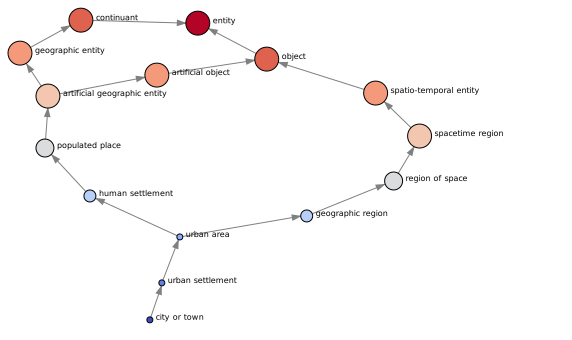

In [20]:
# check the path (city -> entity); also check the roots
adjacency = csr_matrix(nx.adjacency_matrix(graph).toarray())
names = list(graph.nodes)
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q7930989')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8)
SVG(image)

In [19]:
graph8 = copy.deepcopy(graph)

* Step2: Relink the parentTo edges
    * LLMs Judge: only link superclass_of; maual check equivalent relation.
    * Transitive reduction

In [33]:
for nd in list(np.array(names)[ancestors]):
    print(nd, cls2label[nd])

wd:Q7930989 city or town
wd:Q124250988 urban settlement
wd:Q3257686 locality
wd:Q702492 urban area
wd:Q486972 human settlement
wd:Q82794 geographic region
wd:Q123964505 populated place
wd:Q27096235 artificial geographic entity
wd:Q26713767 region of space
wd:Q27096213 geographic entity
wd:Q16686448 artificial object
wd:Q23956024 spacetime region
wd:Q103940464 continuant
wd:Q58415929 spatio-temporal entity
wd:Q488383 object
wd:Q35120 entity


In [31]:
tmp = list(np.array(names)[ancestors]) # graph4 得到的
for link in relinkedParentTo:
    pc, sc = link
    if pc in tmp or sc in tmp:
        print(link, cls2label[pc], cls2label[sc])

('wd:Q486972', 'wd:Q15640612') human settlement fifth-level administrative division
('wd:Q486972', 'wd:Q13221722') human settlement third-level administrative division
('wd:Q3327873', 'wd:Q7930989') local municipality of Quebec city or town
('wd:Q486972', 'wd:Q572975') human settlement opština


In [53]:
for edge in equiv_edges:
    if 'wd:Q486972' in edge:
        print(edge, cls2label[edge[0]], cls2label[edge[1]])

('wd:Q486972', 'wd:Q3257686') human settlement locality


In [54]:
for edge in relinkedParentTo:
    if 'wd:Q486972' in edge:
        print(edge, cls2label[edge[0]], cls2label[edge[1]])

('wd:Q486972', 'wd:Q13221722') human settlement third-level administrative division
('wd:Q486972', 'wd:Q15640612') human settlement fifth-level administrative division
('wd:Q486972', 'wd:Q572975') human settlement opština


In [43]:
len(relinkedParentTo)

279

In [56]:
print("Number of links that need to be relinked:", len(relinkedParentTo))
with open('./data/reprompt_edges.txt', 'w') as f:
    for edge in relinkedParentTo:
        f.write(f"{edge[0]}\t{edge[1]}\n") # parent -> child
# then run the llm_reprompt.py for the reprompting results

Number of links that need to be relinked: 281


In [34]:
# read llm response
PATH = './results/whole_graph'
prompt_files = ['reprompt.tsv']
data = []
for file in prompt_files:
    with open(os.path.join(PATH, file), 'r') as pt_reader:
        qids = None
        explanation = []
        answer = None
        
        for line in pt_reader:
            line = line.strip()
            if line:
                if line.startswith('Explanation:'):
                    # Start a new explanation, capturing all subsequent lines until 'Answer:'
                    explanation = [line]
                elif line.startswith('Answer:'):
                    # Only Capture the first Answer generated
                    answer = line
                    if qids is not None:
                        data.append({
                            'QIDs': qids,
                            'Explanation': ' '.join(explanation),
                            'Answer': answer
                        })
                        # Reset for the next block
                        qids = None
                        explanation = []
                        answer = None
                elif line.startswith('wd:'):
                    qids = line.split('\t')
                else:
                    explanation.append(line)
        
        if qids is not None:
            data.append({
                'QIDs': qids,
                'Explanation': ' '.join(explanation),
                'Answer': answer
            })

In [35]:
# pre-process llm prompts
data_copy = copy.deepcopy(data)
for block in tqdm(data_copy):
    answer = block['Answer']
    answer = process_prompt(answer)
    data[data.index(block)]['Answer'] = answer

# Get the prompt results for each relation
llm_res = []
for block in tqdm(data):
    rel = tuple(block['QIDs'])
    answer = block['Answer']
    if answer.find('none') >= 0 or answer.find(' not ') >= 0:
        answer = '[NONE]'
    
    a_idx = answer.find('concepta')
    b_idx = answer.find('conceptb')
    if a_idx >= 0 or b_idx >= 0:
        if a_idx < b_idx and a_idx >= 0:
            if answer.find('subclass') >= 0:
                answer = '[INVERSE]'
            elif answer.find('superclass') >= 0:
                answer = '[SUPERCLASS]'
            elif answer.find('equivalent') >= 0 or answer.find('equivlant') >= 0 or \
                answer.find('equivant') >= 0 or answer.find('synonym') >= 0:
                answer = '[EQUIV]'
            elif answer.find('irrelevant') >= 0 or answer.find('irrelevent') >= 0 or \
                answer.find('irrelevance') >= 0 or answer.find('irrevelant') >= 0:
                answer = '[IRREL]'
            else:
                answer = '[NONE]'
            
        if b_idx < a_idx and b_idx >= 0:
            if answer.find('subclass') >= 0:
                answer = '[SUPERCLASS]'
            elif answer.find('superclass') >= 0:
                answer = '[INVERSE]'
            elif answer.find('equivalent') >= 0:
                answer = '[EQUIV]'
            elif answer.find('irrelevant') >= 0 or answer.find('irrelevent') >= 0 or \
                answer.find('irrelevance') >= 0 or answer.find('irrevelant') >= 0:
                answer = '[IRREL]'
            else:
                answer = '[NONE]'
        if a_idx >= 0 and b_idx < 0:
            if answer.find('subclass') >= 0 and (answer.find('subclass') < a_idx):
                answer = '[SUPERCLASS]'
            elif answer.find('superclass') >= 0 and (answer.find('superclass') < a_idx):
                answer = '[INVERSE]'
            elif answer.find('irrelevant') >= 0:
                answer = '[IRREL]'
            else:
                answer = '[NONE]'
        if b_idx >= 0 and a_idx < 0:
            if answer.find('superclass') >= 0 and (answer.find('superclass') < b_idx):
                answer = '[SUPERCLASS]'
            elif answer.find('subclass') >= 0 and (answer.find('subclass') < b_idx):
                answer = '[INVERSE]'
            elif answer.find('irrelevant') >= 0:
                answer = '[IRREL]'
            else:
                answer = '[NONE]'
    else:
        if answer.find('irrelevant') >= 0 or answer.find('irrelevent') >= 0:
            answer = '[IRREL]'
        elif answer.find('subclass') >= 0 or answer.find('superclass of') >= 0:
            answer = '[SUPERCLASS]'
        elif answer.find('equivalent') >= 0:
            answer = '[EQUIV]'
        else:
            answer = '[NONE]'
    
    # check before noting
    if answer.startswith('['):
        llm_res.append({
            'relation': rel,
            'llm_answer': answer
        })
    else:
        raise ValueError(f"Answer not valid: {answer}")

100%|██████████| 280/280 [00:00<00:00, 425663.33it/s]


In [36]:
# read the files and only extract [superclass]
torelink_edges = []
for block in llm_res:
    if block['llm_answer'] == '[SUPERCLASS]':
        torelink_edges.append(block['relation'])

In [37]:
len(torelink_edges)

125

In [42]:
for link in torelink_edges:
    print(link, cls2label[link[0]], ';', cls2label[link[1]])

('wd:Q106429267', 'wd:Q106429092') land-based powered military aircraft ; land-based fixed-wing military aircraft
('wd:Q483501', 'wd:Q15977927') artist ; art educator
('wd:Q11538946', 'wd:Q73145133') abstract game player ; chess person
('wd:Q474748', 'wd:Q869923') amphibious assault ship ; helicopter carrier
('wd:Q11446', 'wd:Q16518') ship ; barge
('wd:Q713200', 'wd:Q1658894') performing artist ; illusionist
('wd:Q2578402', 'wd:Q1378235') hand tool ; forceps
('wd:Q29051769', 'wd:Q19710494') exercise ; health enhancing physical activity
('wd:Q177220', 'wd:Q64005969') singer ; calypso musician
('wd:Q40127938', 'wd:Q829504') audio system ; sound reinforcement system
('wd:Q7930989', 'wd:Q3327873') city or town ; local municipality of Quebec
('wd:Q15846749', 'wd:Q123302448') school grounds ; campus
('wd:Q829080', 'wd:Q939871') professional association ; guild
('wd:Q391414', 'wd:Q1131329') architectural element ; grotto
('wd:Q30250610', 'wd:Q844911') object in the outer Solar System ; superi

* relink only the 'superclass' predictions

In [38]:
for edge in tqdm(torelink_edges):
    if not graph.has_node(edge[0]) or not graph.has_node(edge[1]):
        continue
    if graph.has_edge(edge[0], edge[1]):
        continue
    graph.add_edge(edge[0], edge[1])

100%|██████████| 125/125 [00:00<00:00, 131631.43it/s]


In [39]:
# Transitive reduction
print(graph.number_of_edges(), graph.number_of_nodes())
graph = nx.transitive_reduction(graph)
print("After TR", graph.number_of_edges(), graph.number_of_nodes())

28801 24508
After TR 28718 24508


In [62]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 21
Number of roots: 1


(28714, 24506)

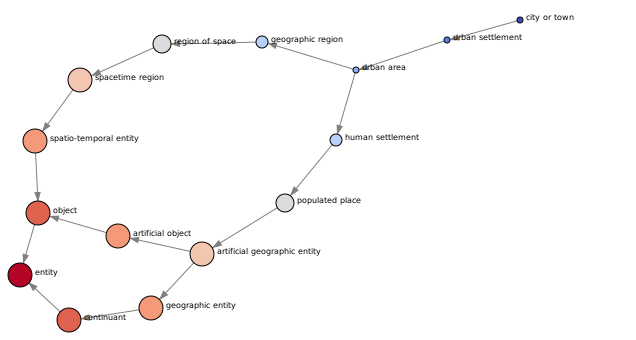

In [23]:
import warnings
warnings.filterwarnings("ignore")
from sknetwork.path import get_distances, breadth_first_search
from sknetwork.visualization import svg_graph
from IPython.display import SVG
import networkx as nx
from scipy.sparse import csr_matrix

adjacency = csr_matrix(nx.adjacency_matrix(graph).toarray())
names = list(graph.nodes)

start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q7930989')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8, width=500)
SVG(image)

In [ ]:
graph5 = copy.deepcopy(graph)

#### Final step: ReOrganize the top1level classes (clean top1 level classes)
* top1level classes, if all their children have links to other non-top1level parents, then we delete this top1level cls.
    * Finding: most deleted top1level classes have only 1/2 children -> make sense -> i.e. unknown, testbed, union, converter, occurent.
* relink/organize the top1level using LLMs. (The gpt prompting process is ignored in this notebook, only results are given)

In [64]:
top1classes = list(graph.successors('wd:Q35120'))
for top1cls in tqdm(top1classes):
    redundancy = True
    for child in graph.successors(top1cls):
        parents = set(graph.predecessors(child)) - set(top1classes)
        if len(parents) == 0:
            redundancy = False
            break
    if redundancy:
        graph.remove_node(top1cls)

100%|██████████| 21/21 [00:00<00:00, 149796.57it/s]


In [65]:
graph.out_degree('wd:Q35120'), graph.in_degree('wd:Q35120')

(17, 0)

In [66]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 21
Number of roots: 1


(28705, 24502)

**As for prompting the top1level classes**
* Ignore equivalent edges -> manual check wired
* superclass edges -> manual check
    * object -> nameless entity, ('wd:Q488383', 'wd:Q42503289')

In [42]:
# graph.remove_edge('wd:Q35120', 'wd:Q42503289') # entity -> nameless entity
# graph.add_edge('wd:Q488383', 'wd:Q42503289') # object -> nameless entity

In [43]:
# print("Is DAG?", nx.is_directed_acyclic_graph(graph))
# print("Is connected?", nx.is_weakly_connected(graph))
# print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
# print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
# graph.number_of_edges(), graph.number_of_nodes()

* additional post-processing
    * Another suggestion for further cleaning the taxonomy: remove recursively any class that has exactly 1 super-class, exactly 1 sub-class and no direct instance; then reconnect directly the sub-class to the super-class if this does not create a transitive link.

In [67]:
# MIN_NUM_DIRECT_INSTS = 3
def find_redundant_nodes(graph, cls_stats):
    redundant_nodes = set()
    for node in graph.nodes():
        if graph.in_degree(node) == 1 and graph.out_degree(node) == 1:
            if node not in cls_stats:
                redundant_nodes.add(node)
            # if node in cls_stats and cls_stats[node] <= MIN_NUM_DIRECT_INSTS:
            #     redundant_nodes.add(node)
            #     continue
    return redundant_nodes

def remove_redundant_nodes(graph, redundant_nodes):
    for node in tqdm(redundant_nodes):
        parent = list(graph.predecessors(node))[0]
        child = list(graph.successors(node))[0]
        graph.remove_node(node)
        if not nx.has_path(graph, parent, child):
            graph.add_edge(parent, child)

# Post-processing
cls_stats = df.set_index('cls').to_dict()['count'] # original cls inst stats
redundant_nodes = find_redundant_nodes(graph, cls_stats)
while len(redundant_nodes) > 0:
    remove_redundant_nodes(graph, redundant_nodes)
    redundant_nodes = find_redundant_nodes(graph, cls_stats)

# transitive reduction
graph = nx.transitive_reduction(graph)

100%|██████████| 20/20 [00:00<00:00, 55151.93it/s]


In [68]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 14
Number of roots: 1


(27601, 23575)

In [69]:
graph6 = copy.deepcopy(graph)

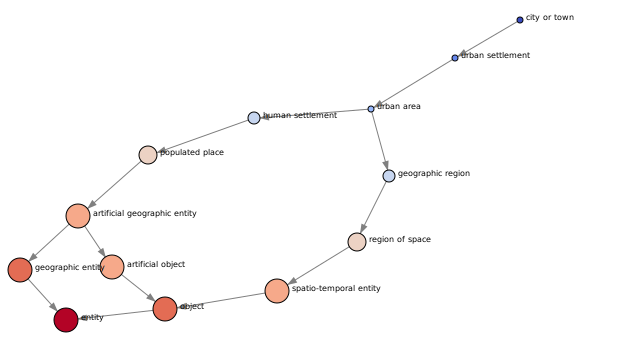

In [70]:
adjacency = csr_matrix(nx.adjacency_matrix(graph).toarray())
names = list(graph.nodes)

start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q7930989')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8, width=500)
SVG(image)

* Try multiple languages
    * en, fr, de, zh, ar
    * If either of them has a wikipedia mapping -> we keep this class.

In [3]:
import networkx as nx

wikitaxonDown = defaultdict(set)
with open('./data/graph/clean_wikiTaxonUp6.tsv', 'r') as file:
    for line in file:
        child, parent = line.strip().split('\t')
        wikitaxonDown[parent].add(child)
graph = nx.DiGraph(wikitaxonDown)

In [4]:
# test: additional post-processing
import os
from tqdm import tqdm
mapped_wiki_ents = set()
wikipedia_lists = ['enwiki', 'frwiki', 'dewiki', 'zhwiki', 'arwiki']
for wikifile in tqdm(wikipedia_lists):
    with open(os.path.join('./data/wikipedia', wikifile), 'r') as file:
        for line in file:
            qid = line.strip().split(',')[1]
            mapped_wiki_ents.add('wd:'+str(qid))
print(len(mapped_wiki_ents))

100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

13963881


In [6]:
mapped_cls = set(graph.nodes()).intersection(mapped_wiki_ents)
len(mapped_cls)

16395

In [8]:
if 'wd:Q7930989' in mapped_cls:
    print("City is in the mapped classes.")

if 'wd:Q66666685' in mapped_cls:
    print("Academic is in the mapped classes.")

if 'wd:Q3400985' in mapped_cls:
    print("Academic is in the mapped classes.")

City is in the mapped classes.
Academic is in the mapped classes.


* One more step: we keep all top level (**level=3**) classes, as they are top level, which may be more abstract in labels to cover everthing, causing no mapping in wikipedia. But we want to keep them (intuition: want to keep "artificial object" in clean wikidata taxonomy.)

In [74]:
# Get all nodes within depth <= 3
top_cls = set(nx.single_source_shortest_path_length(graph, source='wd:Q35120', cutoff=3).keys())
print(len(top_cls))
mapped_cls.update(top_cls)
print(len(mapped_cls))

675
16613


In [75]:
# keep only mapped cls and reconnect graph
global mapped_cls
def get_ancestors(digraph, ancestors, cls):
    for sp in digraph.predecessors(cls):
        if sp in mapped_cls:
            ancestors.add(sp)
            continue
        get_ancestors(digraph, ancestors, sp)

def get_valid_first_ancestors(digraph, cls):
    ancestors = set()
    get_ancestors(digraph, ancestors, cls)
    return ancestors

In [76]:
# Original WikiTaxonomy (whole)
G_original = copy.deepcopy(graph)

# Rebuild the subgraph from the extracted classes
G_subgraph = nx.DiGraph()
for node in mapped_cls:
    G_subgraph.add_node(node)

for node in tqdm(mapped_cls):
    ancestors = get_valid_first_ancestors(G_original, node)
    for ancestor in ancestors:
        G_subgraph.add_edge(ancestor, node) # direction: parent -> child
subgraph = nx.transitive_reduction(G_subgraph)

# check the properties of the subgraph
print("Is DAG?", nx.is_directed_acyclic_graph(subgraph))
print("Is connected?", nx.is_weakly_connected(subgraph))
print("Max Depth:", max(nx.shortest_path_length(subgraph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in subgraph.nodes() if subgraph.in_degree(node) == 0]))
subgraph.number_of_edges(), subgraph.number_of_nodes()

100%|██████████| 16613/16613 [00:00<00:00, 356952.44it/s]


Is DAG? True
Is connected? True
Max Depth: 13
Number of roots: 1


(19654, 16613)

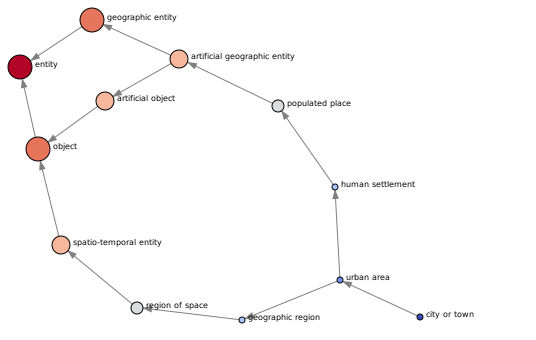

In [30]:
import warnings
warnings.filterwarnings("ignore")
from sknetwork.path import get_distances, breadth_first_search
from sknetwork.visualization import svg_graph
from IPython.display import SVG
import networkx as nx
from scipy.sparse import csr_matrix

adjacency = csr_matrix(nx.adjacency_matrix(graph).toarray())
names = list(graph.nodes)

start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q7930989')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8, width=400)
SVG(image)

In [80]:
graph7 = copy.deepcopy(subgraph)

In [78]:
graph = copy.deepcopy(subgraph)

In [31]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 13
Number of roots: 1


(19654, 16613)

In [32]:
# Check if important classes are still in the graph
# Refer to YAGO4.5 design file: https://yago-knowledge.org/data/yago4.5/
# Creative work; Q17537576; Q386724
print("-Creative work-", "IncludeCls:", graph.has_node('wd:Q17537576'), 
      " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q17537576'))
print("-Creative work-", "IncludeCls:", graph.has_node('wd:Q386724'))
# Book; Q571
print("-Book-", "IncludeCls:", graph.has_node('wd:Q571'), 
      " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q571'))
# Newspaper; Q11032
print("-Newspaper-", "IncludeCls:", graph.has_node('wd:Q11032'), 
      " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q11032'))
# TVSeries; Q5398426
print("-TVSeries-", "IncludeCls:", graph.has_node('wd:Q5398426'), 
      " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q5398426'))
# MusicComposition; Q207628; Q2188189
print("-MusicComposition-", "IncludeCls:", graph.has_node('wd:Q207628'))
print("-MusicComposition-", "IncludeCls:", graph.has_node('wd:Q2188189'))
print("-Music-", "IncludeCls:", graph.has_node('wd:Q638'))
# Movie, Q11424
print("-Movie-", "IncludeCls:", graph.has_node('wd:Q11424'), 
      " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q11424'))
# Event, Q1190554; Q1656682
print("-Event-", "IncludeCls:", graph.has_node('wd:Q1190554'))
print("-Event-", "IncludeCls:", graph.has_node('wd:Q1656682'))
# Election, Q40231
print("-Election-", "IncludeCls:", graph.has_node('wd:Q40231'))
print("-Election-", "IncludeCls:", graph.has_node('wd:Q189760')) # voting
print("-Election-", "IncludeCls:", graph.has_node('wd:Q12888920')) # selection
print("-Election-", "IncludeCls:", graph.has_node('wd:Q2135540')) # legal action
print("-Election-", "IncludeCls:", graph.has_node('wd:Q1864008')) # legal art
print("-Election-", "IncludeCls:", graph.has_node('wd:Q1331926')) # descision making
# Organization, Q43229
print("-Organization-", "IncludeCls:", graph.has_node('wd:Q43229'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q43229'))
# Corporation, Q783794; Q4830453
print("-Corporation-", "IncludeCls:", graph.has_node('wd:Q783794'))
print("-Corporation-", "IncludeCls:", graph.has_node('wd:Q4830453'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q4830453'))
# Airline, Q46970
print("-Airline-", "IncludeCls:", graph.has_node('wd:Q46970'))
print("-Airline-", "IncludeCls:", graph.has_node('wd:Q1875615')) # aircraft operator
# EducationalOrganization, Q5341295
print("-EducationalOrganization-", "IncludeCls:", graph.has_node('wd:Q5341295'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q5341295'))
# PerformingGroup, Q105815710
print("-PerformingGroup-", "IncludeCls:", graph.has_node('wd:Q105815710'))
# MusicGroup, Q2088357
print("-MusicGroup-", "IncludeCls:", graph.has_node('wd:Q2088357'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q2088357'))
# Person, Q5; Q215627
# print("-Person-", "IncludeCls:", graph.has_node('wd:Q5'),
#         " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q5'))
print("-Person-", "IncludeCls:", graph.has_node('wd:Q215627'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q215627'))
# Worker, Q702269, Q327055
print("-Worker-", "IncludeCls:", graph.has_node('wd:Q702269'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q702269'))
print("-Worker-", "IncludeCls:", graph.has_node('wd:Q327055'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q327055'))
# Creator, Q483501
print("-Creator-", "IncludeCls:", graph.has_node('wd:Q483501'))
print("-Creator-", "IncludeCls:", graph.has_node('wd:Q2500638'))
# Academic, Q66666685
print("-Academic-", "IncludeCls:", graph.has_node('wd:Q66666685'))
print("-Academic-", "IncludeCls:", graph.has_node('wd:Q3400985'))
# SportsPerson, Q50995749
print("-SportsPerson-", "IncludeCls:", graph.has_node('wd:Q50995749'))
# Politician, Q82955
print("-Politician-", "IncludeCls:", graph.has_node('wd:Q82955'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q82955'))
# AdministrativeArea, Q56061
print("-AdministrativeArea-", "IncludeCls:", graph.has_node('wd:Q56061'))
print("-AdministrativeArea-", "IncludeCls:", graph.has_node('wd:Q15642541')) # human-geographic territorial entity
# # City, Q515, Q7930989
# print("-City-", "IncludeCls:", graph.has_node('wd:Q515'),
#         " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q515'))
print("-City-", "IncludeCls:", graph.has_node('wd:Q7930989'))
# Country, Q6256
print("-Country-", "IncludeCls:", graph.has_node('wd:Q6256'))
print("-Country-", "IncludeCls:", graph.has_node('wd:Q1048835')) # political territorial entity
# Landform, Q14524493, Q205895, Q2221906, Q35145263, Q271669, Q3622002, Q82794
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q14524493'))
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q205895'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q205895'))
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q2221906')) # geographic location -> P31:type of property
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q35145263'))
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q271669'))
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q3622002'))
print("-Landform-", "IncludeCls:", graph.has_node('wd:Q82794'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q82794'))
# BodyOfWater, Q15324, Q116126039
print("-BodyOfWater-", "IncludeCls:", graph.has_node('wd:Q15324'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q15324'))
print("-BodyOfWater-", "IncludeCls:", graph.has_node('wd:Q116126039'))
# Continent, Q5107
print("-Continent-", "IncludeCls:", graph.has_node('wd:Q5107'),
        " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q5107'))
# HumanMadeGeographicalEntity, Q811979, Q811430, Q811463, Q35145743
print("-HumanMadeGeographicalEntity-", "IncludeCls:", graph.has_node('wd:Q811979'))
print("-HumanMadeGeographicalEntity-", "IncludeCls:", graph.has_node('wd:Q811430'))
print("-HumanMadeGeographicalEntity-", "IncludeCls:", graph.has_node('wd:Q811463'))
print("-HumanMadeGeographicalEntity-", "IncludeCls:", graph.has_node('wd:Q35145743'))
print("-HumanMadeGeographicalEntity-", "IncludeCls:", graph.has_node('wd:Q11908691'))
# Way, Q83620
print("-Way-", "IncludeCls:", graph.has_node('wd:Q83620'))
# Airport, Q1248784
print("-Airport-", "IncludeCls:", graph.has_node('wd:Q1248784'))
print("-Airport-", "IncludeCls:", graph.has_node('wd:Q62447')) 
# AstronomicalObject, Q6999
print("-AstronomicalObject-", "IncludeCls:", graph.has_node('wd:Q6999'))
print("-AstronomicalObject-", "IncludeCls:", graph.has_node('wd:Q4235019')) # space object
# Product, Q2424752
print("-Product-", "IncludeCls:", graph.has_node('wd:Q2424752'))
# # Taxon, Q16521
# print("-Taxon-", "IncludeCls:", graph.has_node('wd:Q16521'),
#         " **Depth: ", nx.shortest_path_length(graph, source='wd:Q35120', target='wd:Q16521'))
# Award, Q618779
print("-Award-", "IncludeCls:", graph.has_node('wd:Q618779'))
# belief system (Q5390013)
print("-belief system-", "IncludeCls:", graph.has_node('wd:Q5390013'))
# Language, Q34770
print("-Language-", "IncludeCls:", graph.has_node('wd:Q34770'))
# Gender, Q48264
print('-Gender-', "IncludeCls:", graph.has_node('wd:Q48264'))
# FictionalEntity, Q14897293, Q115537581, Q64728693, Q18706315, Q21070598
print("-FictionalEntity-", "IncludeCls:", graph.has_node('wd:Q14897293'))
print("-FictionalEntity-", "IncludeCls:", graph.has_node('wd:Q115537581')) # imaginary character P279 agent(removed)
print("-FictionalEntity-", "IncludeCls:", graph.has_node('wd:Q64728693'))
print("-FictionalEntity-", "IncludeCls:", graph.has_node('wd:Q18706315'))
print("-FictionalEntity-", "IncludeCls:", graph.has_node('wd:Q21070598'))

-Creative work- IncludeCls: True  **Depth:  4
-Creative work- IncludeCls: True
-Book- IncludeCls: True  **Depth:  3
-Newspaper- IncludeCls: True  **Depth:  4
-TVSeries- IncludeCls: True  **Depth:  6
-MusicComposition- IncludeCls: True
-MusicComposition- IncludeCls: True
-Music- IncludeCls: False
-Movie- IncludeCls: True  **Depth:  6
-Event- IncludeCls: True
-Event- IncludeCls: True
-Election- IncludeCls: True
-Election- IncludeCls: True
-Election- IncludeCls: True
-Election- IncludeCls: False
-Election- IncludeCls: True
-Election- IncludeCls: True
-Organization- IncludeCls: True  **Depth:  4
-Corporation- IncludeCls: False
-Corporation- IncludeCls: True  **Depth:  5
-Airline- IncludeCls: True
-Airline- IncludeCls: True
-EducationalOrganization- IncludeCls: True  **Depth:  5
-PerformingGroup- IncludeCls: True
-MusicGroup- IncludeCls: True  **Depth:  6
-Person- IncludeCls: True  **Depth:  4
-Worker- IncludeCls: True  **Depth:  6
-Worker- IncludeCls: True  **Depth:  5
-Creator- IncludeCls

#### Store the results and Visualize

In [48]:
# Store the final cleaned taxonomy
with open('./data/graph/clean_wikiTaxonUp0.tsv', 'w') as taxowriter:
    for edge in graph1.edges():
        parent, child = edge
        taxowriter.write(child+'\t'+parent+'\n')

In [25]:
from collections import defaultdict
cleanWikiTaxonDown = defaultdict(set)
with open('./data/graph/clean_wikiTaxonUp7.tsv', 'r') as taxoreader:
    for line in taxoreader:
        child, parent = line.strip().split('\t')
        cleanWikiTaxonDown[parent].add(child)
graph = nx.DiGraph(cleanWikiTaxonDown)

In [53]:
def generate_html(node, taxonomy):
    html = '<ul>'
    for child in taxonomy.get(node, []):
        html += f'<li><span class="toggle" onclick="toggleChildren(this)">&#9660;</span>{cls2label[child]}({child[3:]})<ul class="children">'
        html += generate_html(child, taxonomy)
        html += '</ul></li>'
    html += '</ul>'
    return html

In [54]:
# Create the HTML content
html_content = generate_html('wd:Q35120', cleanWikiTaxonDown)

# Generate the complete HTML file
html_template = f'''
<!DOCTYPE html>
<html>
<head>
    <style>
        ul {{
            list-style-type: none;
        }}
        li {{
            padding-left: 10px;
        }}
        .toggle {{
            cursor: pointer;
            color: black;
        }}
        .children {{
            display: none;
        }}
    </style>
    <script>
        function toggleChildren(element) {{
            var ul = element.nextElementSibling;
            if (ul.style.display === 'none' || ul.style.display === '') {{
                ul.style.display = 'block';
                element.textContent = '▶';
                element.style.color = 'blue';
            }} else {{
                ul.style.display = 'none';
                element.textContent = '▼';
                element.style.color = 'black';
            }}
        }}
    </script>
</head>
<body>
    <h1>Clean Wikidata Taxonomy</h1>
    {html_content}
</body>
</html>
'''

# Write the HTML content to a file
with open("cleanWikiTaxon.html", "w") as html_file:
    html_file.write(html_template)

print("HTML file generated: class_hierarchy.html")

HTML file generated: class_hierarchy.html


### Draw graph to check some important classes

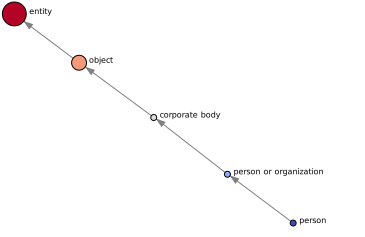

In [33]:
import warnings
warnings.filterwarnings("ignore")
from sknetwork.path import get_distances, breadth_first_search
from sknetwork.visualization import svg_graph
from IPython.display import SVG
import networkx as nx
from scipy.sparse import csr_matrix

# graph = nx.DiGraph(cleanWikiTaxonDown)
adjacency = csr_matrix(nx.adjacency_matrix(graph).toarray())
names = list(graph.nodes)

start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q215627')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=0.7, font_size=8)
SVG(image)

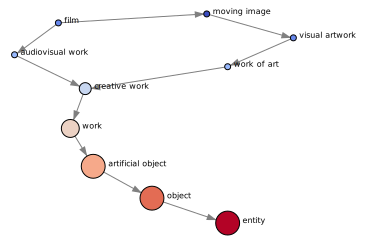

In [34]:
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q11424')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=0.7, font_size=8)
SVG(image)

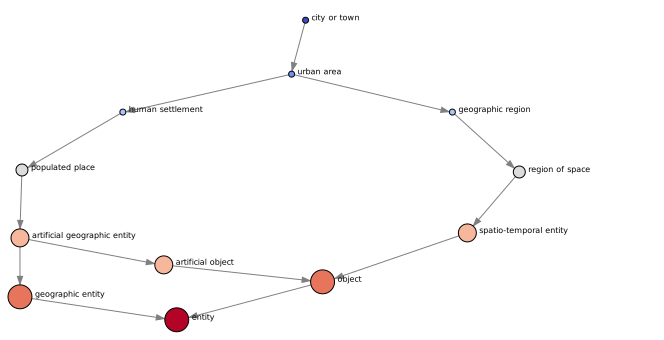

In [35]:
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q7930989')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8, width=500)
SVG(image)

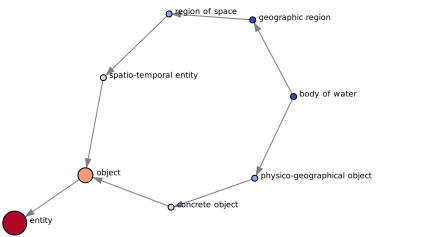

In [36]:
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q15324')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=0.7, font_size=8)
SVG(image)

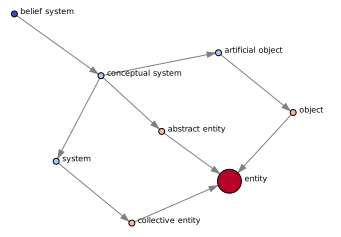

In [37]:
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q5390013')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=0.7, font_size=8)
SVG(image)

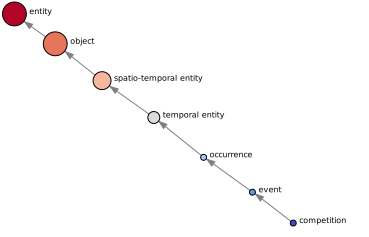

In [38]:
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q476300')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=0.7, font_size=8)
SVG(image)

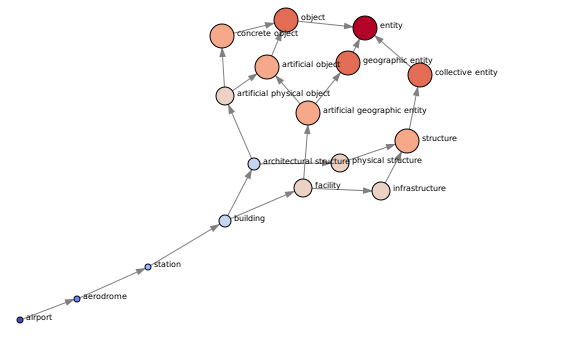

In [39]:
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q1248784')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8)
SVG(image)

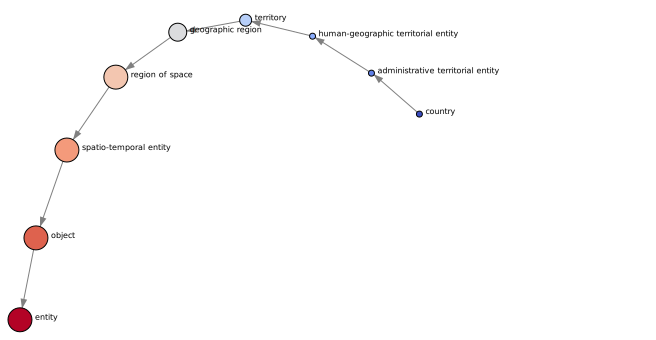

In [43]:
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q6256')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8)
SVG(image)

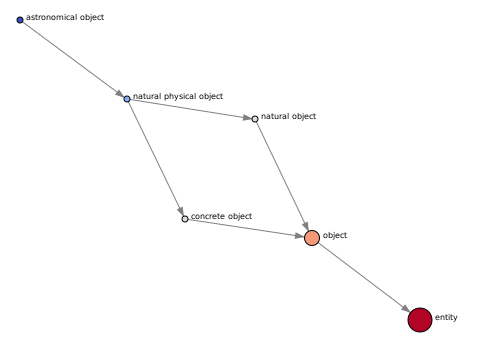

In [44]:
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q6999')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8)
SVG(image)

In [ ]:
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q618779')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1, font_size=8)
SVG(image)

### Additional -> canceled

In [78]:
# How many classes have only one child?
single_child_classes = [node for node in graph.nodes() if graph.out_degree(node) == 1]
len(single_child_classes)

3157

In [ ]:
def has_continous_single_child(cls, digraph, candidates, depth=1):
    for pc in graph.predecessors(cls):
        if pc in candidates:
            has_continous_single_child(pc, digraph, candidates, depth+1)

In [101]:
import networkx as nx
def get_single_depth(graph, node):
    depth = 0
    parent = node
    while True:
        successors = list(graph.successors(parent))
        if len(successors) == 1:
            depth += 1
            parent = successors[0]
        else:
            break
    return depth

In [108]:
for cls in tqdm(single_child_classes):
    single_depth = get_single_depth(graph, cls)
    if single_depth > 2:
        depth = nx.shortest_path_length(graph, source='wd:Q35120', target=cls)
        print(single_depth, depth, cls, cls2label[cls])

100%|██████████| 3157/3157 [00:00<00:00, 424540.49it/s]

3 8 wd:Q63973241 military aircraft with propellers
3 10 wd:Q106429086 land-based fixed-wing combat aircraft
3 10 wd:Q106429253 land-based powered combat aircraft
3 8 wd:Q106863327 water-based military aircraft
3 6 wd:Q116877139 visual aid
3 8 wd:Q178777 jet engine
3 5 wd:Q4810574 mobile robot
3 5 wd:Q47465687 fictional personal weapon
4 7 wd:Q743004 aircraft engine
3 5 wd:Q17504947 tool handle
4 5 wd:Q11068 circulatory system
3 6 wd:Q382386 vessel
3 4 wd:Q811433 toy block
3 3 wd:Q29896155 difference
3 5 wd:Q1402516 matchstick graph
3 5 wd:Q1322892 chordal graph
4 4 wd:Q15297198 mechanical system
3 5 wd:Q1798773 HVAC
3 5 wd:Q61760621 group of monuments
3 6 wd:Q1202618 sports field
4 6 wd:Q57659484 exhibition hall
3 7 wd:Q57659763 animal exhibition building
3 5 wd:Q61465712 multi-sided market
3 5 wd:Q122261772 digital atlas
3 7 wd:Q2352921 offense against sexual self-determination
3 6 wd:Q30314000 physical disorder
3 7 wd:Q3339235 neurological disorder
4 6 wd:Q55093063 nutritional and me

In [110]:
graph.number_of_edges(), graph.number_of_nodes()

(26570, 21872)

In [111]:
nx.transitive_reduction(graph).number_of_edges(), nx.transitive_reduction(graph).number_of_nodes()

(26570, 21872)

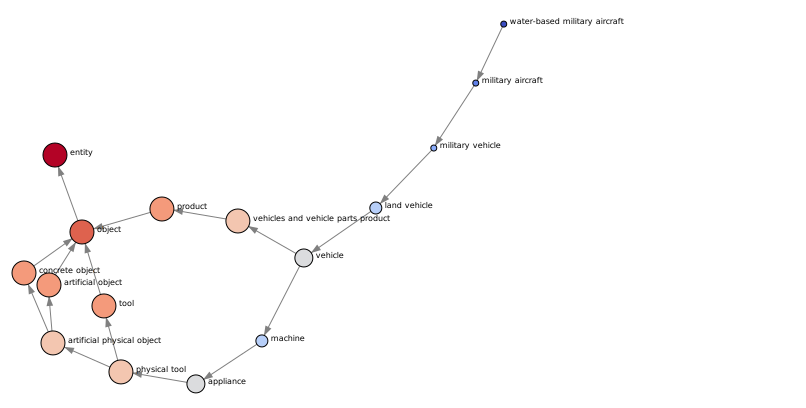

In [118]:
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q106863327')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1.2, font_size=8, height=300)
SVG(image)

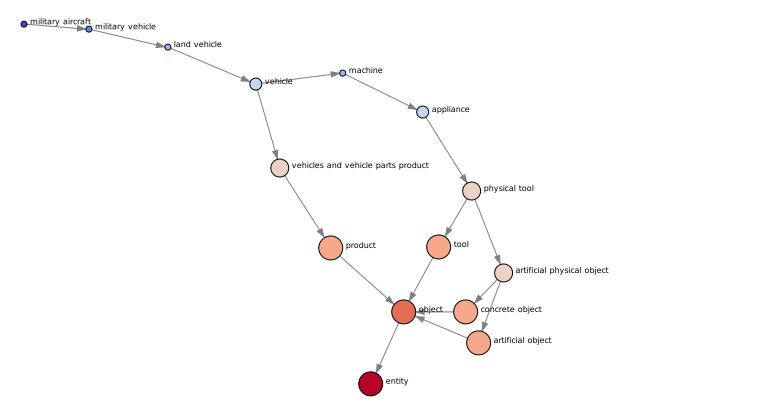

In [12]:
import numpy as np
start_index = names.index('wd:Q35120')
end_index = names.index('wd:Q216916')
adjacency_transpose = adjacency.T # subclass_of relation
ancestors = breadth_first_search(adjacency_transpose, source=end_index)
exart_human_entity = adjacency_transpose[ancestors, :][:, ancestors]
human_entity_names = list(np.array(names)[ancestors])

entity_index = human_entity_names.index('wd:Q35120')
distances = get_distances(exart_human_entity.T, source=entity_index)
human_entity_names = [cls2label[qid] for qid in human_entity_names]
weights = np.clip(~distances+max(distances) - 1, a_min=0, a_max=3) 
image = svg_graph(exart_human_entity, names=human_entity_names, display_node_weight=True, 
                  node_weights=weights, node_size_max=12, node_size_min=3,
                  scores=-distances, scale=1.2, font_size=8, height=300)
SVG(image)